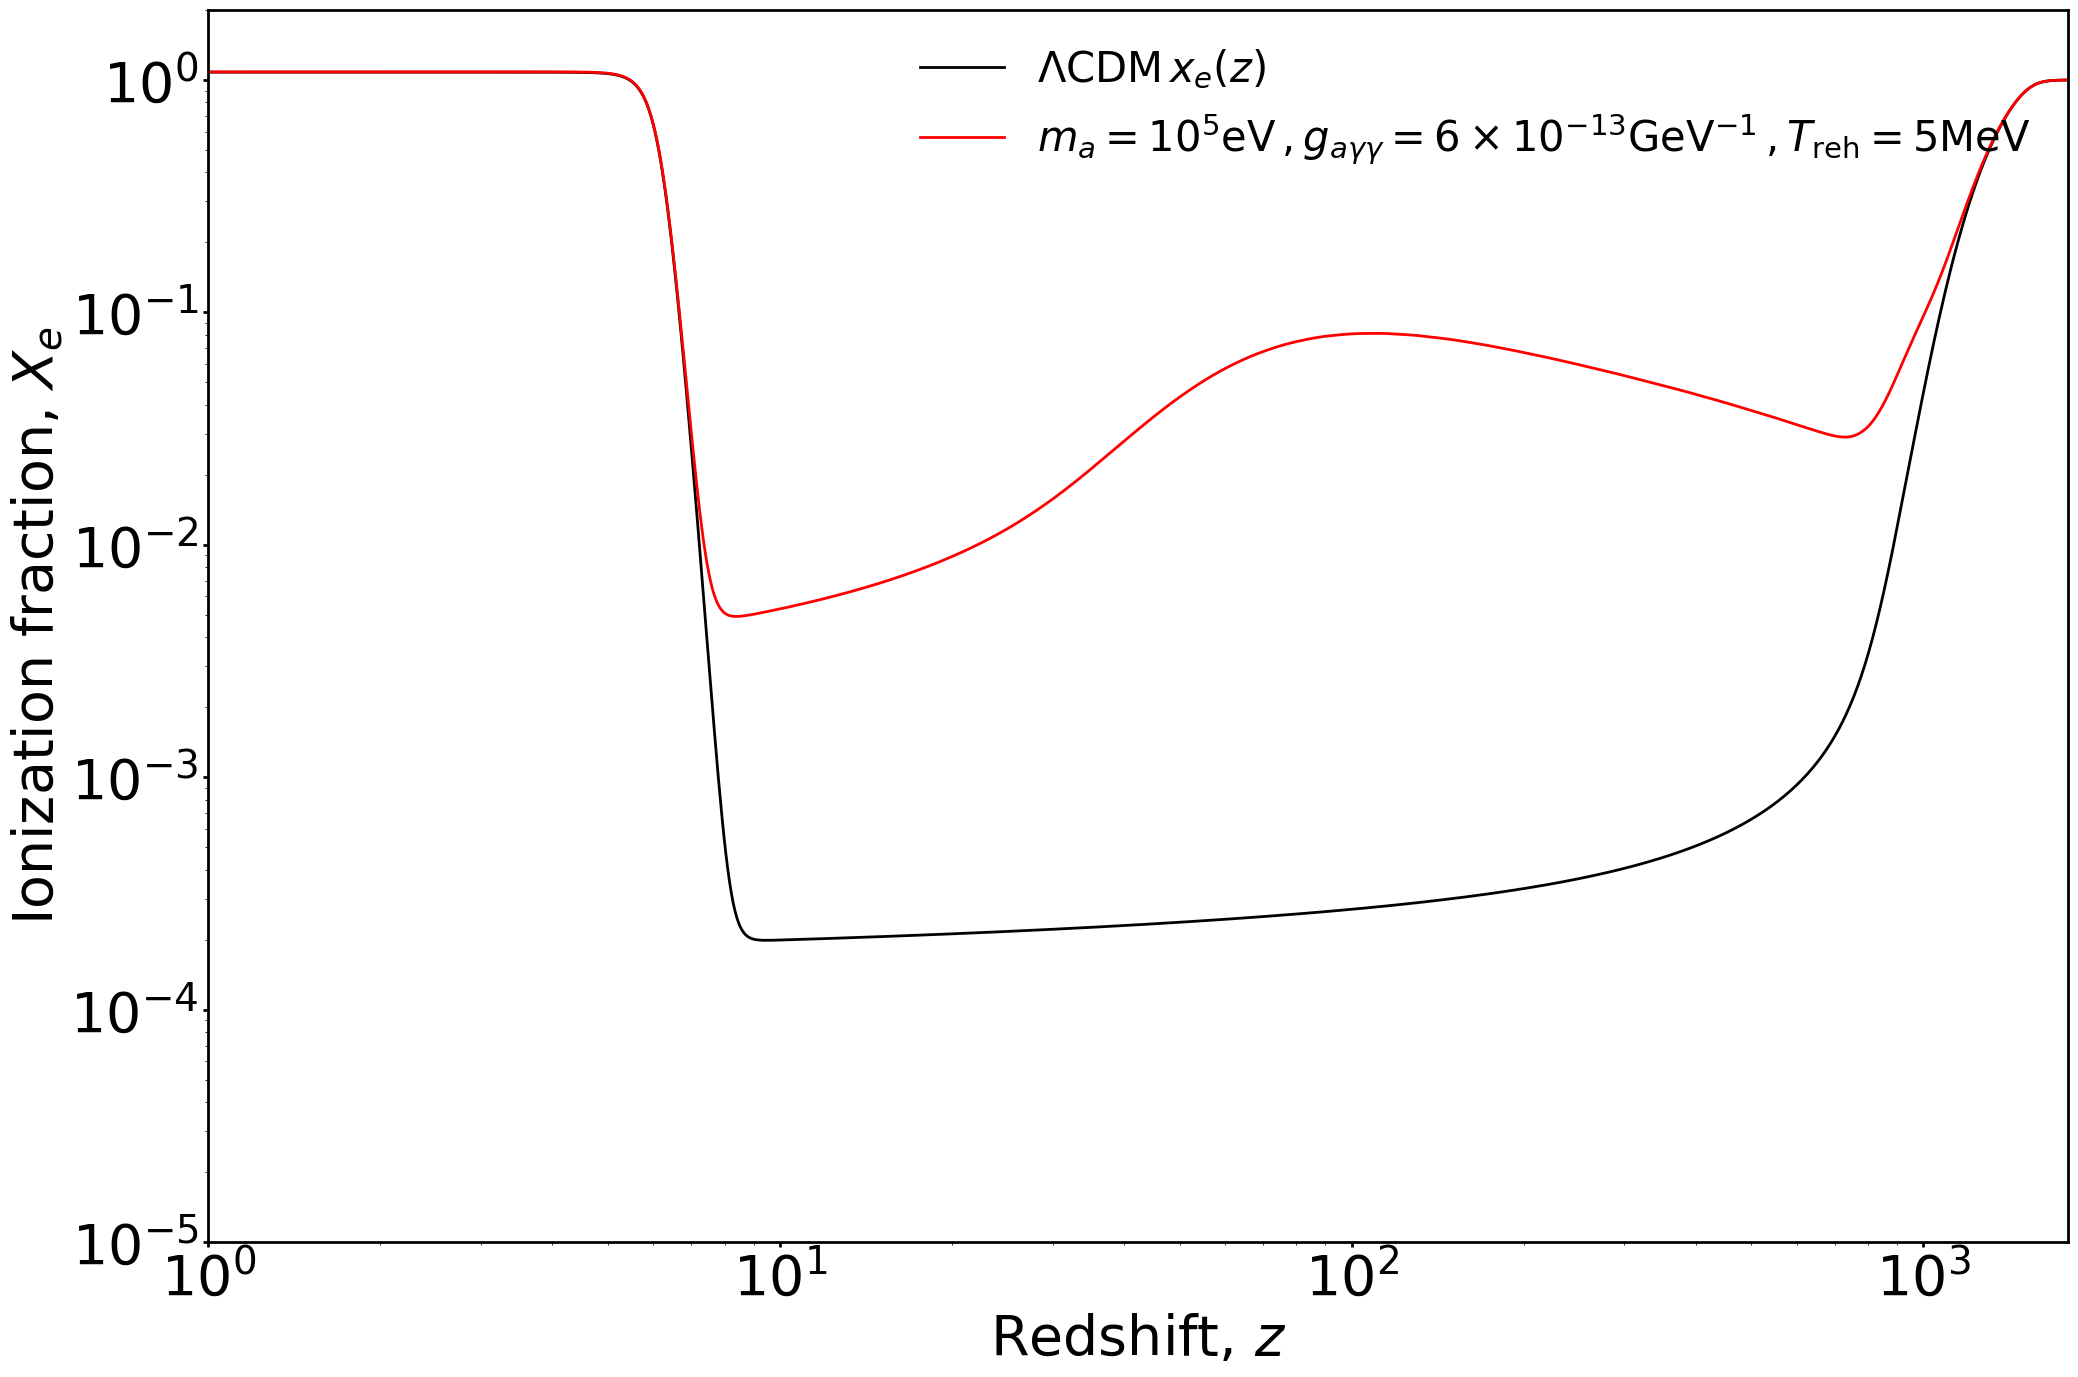

optical depth of LCMB is: 0.040732240325404
[1.00000000e+14 2.15443469e+15 4.64158883e+16 1.00000000e+18]
optical depth for different reheating temperature [np.float64(0.045848122812366984), np.float64(0.10382632407600516), np.float64(0.45745876737120206), np.float64(2.2157687790234974)]


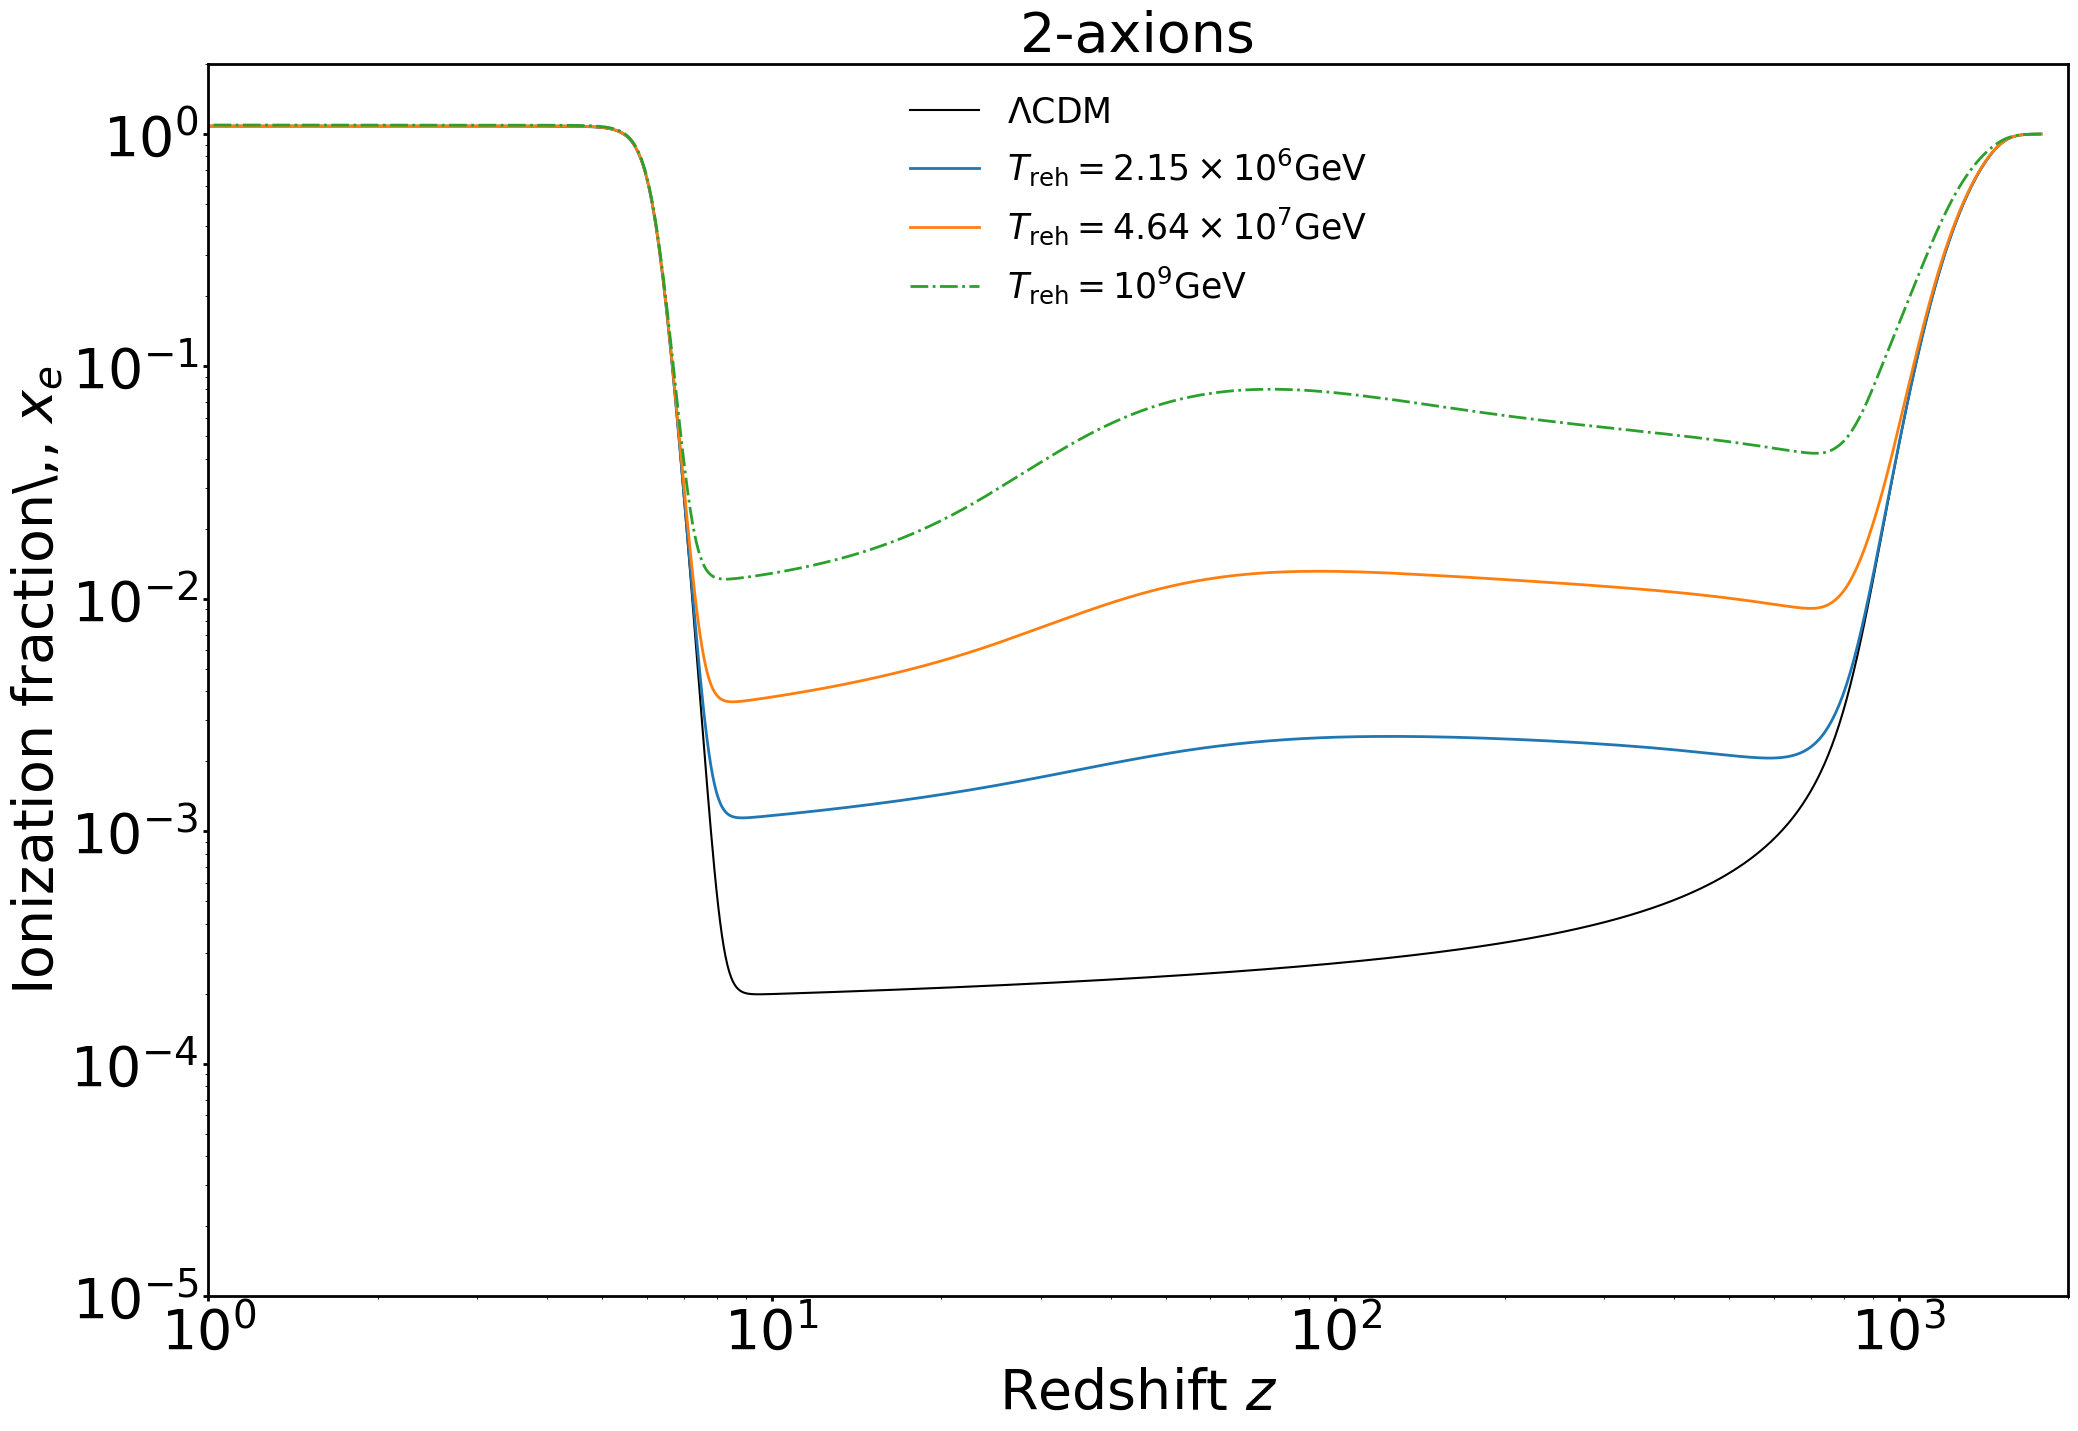

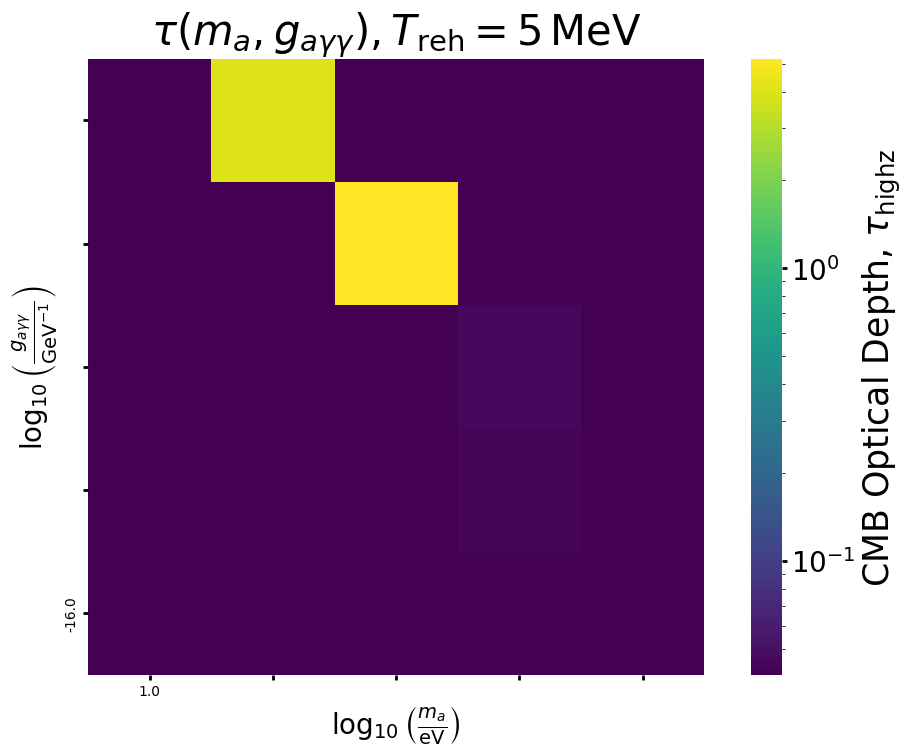

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import math
import seaborn as sns
import darkhistory.physics as phys
import darkhistory.history.tla as hist
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp


###############################every thing in eV or eV^{-1} in this file######################
η_10=6.1#10^10*n_N/n_γ
B_H=13.6#eV
T0=2.7/11605#eV
ρ_c=4*10**(-11)#eV^4
H_0=1.5*10**(-33)#eV
Y_p=0.25
f_He=1*Y_p/(4*(1-Y_p))#arXiv:1306.0563v1 eq.11
Q_p=0.99986# reionization empirical parametrization
z_p=6.1
λ=0.73
ρ_γ=2*10**-15
m_e=0.511*10**6
Aprim=1
g_star=10.74#for T=5Mev(the freeze-in abundance dependence on g* is \sqrt{g*} there will be only an O(1) difference)
g_star_id=10.73

Ω_m=0.3158
σ_t=1.7078*10**-15 #eV^-2
z_rei=6.1
delta_z=0.5# input parameter from reionization 	arXiv:0804.3865
T_range=np.logspace(np.log10(5*10**6),25,19)

def cotanh(x):
   return 1/math.tanh(x)

def Γ(g_aγγ,m_a):
    return g_aγγ**2*m_a**3/(64*np.pi)

def α(z):
    return np.exp(37.7)*(B_H/(T0*(1+z)))**1.5*np.exp(-B_H/(T0*(1+z)))*np.exp(-np.log(η_10))

def xe_rec(z):
    result=(-α(z)+np.sqrt(α(z)**2+4*α(z)))/2
    if result<10**-4:
       return result+10**-4
    else:
     return result

#Axion decay(beyond-on-the-spot assumption)
def E_inj(z,g_aγγ,m_a,f_dm):
    
    result=Γ(g_aγγ,m_a)*np.exp(-Γ(g_aγγ,m_a)*(t(z)))*0.27*ρ_c*f_dm*(1+z)**3 
    return result 

def t(z):
    return 2*np.arcsinh(np.sqrt(0.7/(0.3*(1+z)**3)))/(3*H_0*np.sqrt(0.7))

def f(z,g_aγγ,m_a,f_eff):
    return f_eff*np.exp(-Γ(g_aγγ,m_a)*t(z))




def N_H(z):
    return 3.1*10**(-8)*η_10*(1+z)**3*7.71*10**(-15)
#reionization 6<z<20

def xe_rei(z):
   return 1.08*(1+np.tanh(((1+z_rei)**1.5-(1+z)**1.5)/(1.5*(1+z_rei)**0.5*delta_z)))/2
   
     
def dxe_rei_dz(z):
   return -0.5*(1+f_He)*(np.sqrt(z)/(delta_z*np.sqrt(1+z))+(-z**1.5+(1+z_rei)**1.5)/(3*delta_z*(1+z)**1.5))*(np.cosh(2*(-z**1.5+(1+z_rei)**1.5)/(3*delta_z*np.sqrt(1+z))))**-2



def F_apr(m,g,T_r):
    return Aprim/np.sqrt(g_star)*2.4*10**-8*(g/(10**-20))**2*(T_r/10**7)*(m/T_r)**3*1.2*T_r**3/(np.pi**2)/(0.27*4*10**-11*(m/T0)**3)*m  #for m<<Treh
   # return Aprim/np.sqrt(g_star)*2.4*10**-8*(T_r/(10**7))*(g/(10**-20))**2*(T0/T_r)**3*m*n_eq(m,T_r)/(0.27*ρ_c)# full expression

def A_id(m):
   if m <=10**6:
      return 0.16*(m/(10**6))**-0.53
   else:
      return 0.16
   
def F_aid(m,g,T_r):
   T_id=2.5*m
   if T_r>=T_id:
    return A_id(m)/np.sqrt(g_star_id)*(1.42*10**-4)*(g/(10**-20))**2*(m/10**5)**2
   else:
      if 8*(T_r/T_id)**3-1>=0:
       return A_id(m)/np.sqrt(g_star_id)*(1.42*10**-4)*(g/(10**-20))**2*(m/10**5)**2*((T_r/T_id*(4*(T_r/T_id)**2-1)**1.5)/(3**1.5)*cotanh(0.1*T_id/T_r)/cotanh(0.1))
      else:
         return 0 
   
      


def H(z):
   return H_0*np.sqrt(Ω_m*(1+z)**3+(1-Ω_m))

def dτ(zinv,xee):
   dtau=[]
   xee_new=np.flip(xee)
   for i in zinv:
     tt=xee_new[np.where(zinv==i)[0][0]]*N_H(i)*σ_t*((1+i)*H(i))**-1
     dtau.append(tt)

   return dtau  
   

      
def dz(zz):
   return zz*(np.log10(max(zz))-np.log10(min(zz)))/len(zz)      

def f_c_ion_list(z,m):
   if isinstance(m,list):
    m=np.array(m)
    num=len(m)
    fch=np.empty((num,1000)).tolist()
    for mi in m:
     xi=np.where(m==mi)[0][0]
     fch[xi]=phys.f_std(mDM=mi,rs=z,inj_particle='phot',inj_type='decay',struct=False,channel='H ion')

    return  fch 
   
   else:     
      return phys.f_std(mDM=m,rs=z,inj_particle='phot',inj_type='decay',struct=False,channel='H ion')   


def f_c_heat_list(z,m):
   if isinstance(m,list):
    m=np.array(m)
    num=len(m)
    fch=np.empty((num,1000)).tolist()
    for mi in m:
     xi=np.where(m==mi)[0][0]
     fch[xi]=phys.f_std(mDM=mi,rs=z,inj_particle='phot',inj_type='decay',struct=False,channel='heat')

    return  fch 
   
   else:     
      return phys.f_std(mDM=m,rs=z,inj_particle='phot',inj_type='decay',struct=False,channel='heat')
   
def f_c_exc_list(z,m):
   if isinstance(m,list):
    m=np.array(m)
    num=len(m)
    fch=np.empty((num,1000)).tolist()
    for mi in m:
     xi=np.where(m==mi)[0][0]
     fch[xi]=phys.f_std(mDM=mi,rs=z,inj_particle='phot',inj_type='decay',struct=False,channel='exc')

    return  fch 
   
   else:     
      return phys.f_std(mDM=m,rs=z,inj_particle='phot',inj_type='decay',struct=False,channel='exc')   

def K_h(m,g,Tr,f_h,zz):

   if isinstance(m,list):
      m=np.array(m)
      num=len(m)
      sum=0
      for i in range(num):
         fi=F_apr(m[i],g[i],Tr)+F_aid(m[i],g[i],Tr)
         f_h_i=f_h[i]
         sum=sum+E_inj(zz,g[i],m[i],fi)*f_h_i(zz)

      return sum/N_H(zz)    

   else:
      fi=F_apr(m,g,Tr)+F_aid(m,g,Tr)
      return E_inj(zz,g,m,fi)*f_h(zz)/N_H(zz)  
   
def K_ion(m,g,Tr,f_ion,zz):

   if isinstance(m,list):
      m=np.array(m)
      num=len(m)
      sum=0
      for i in range(num):
         fi=F_apr(m[i],g[i],Tr)+F_aid(m[i],g[i],Tr)
         f_ion_i=f_ion[i]
         sum=sum+E_inj(zz,g[i],m[i],fi)*f_ion_i(zz)

      return sum  

   else:
      fi=F_apr(m,g,Tr)+F_aid(m,g,Tr)
      return E_inj(zz,g,m,fi)*f_ion(zz)

def K_exc(m,g,Tr,f_exc,zz):

   if isinstance(m,list):
      m=np.array(m)
      num=len(m)
      sum=0
      for i in range(num):
         fi=F_apr(m[i],g[i],Tr)+F_aid(m[i],g[i],Tr)
         f_exc_i=f_exc[i]
         sum=sum+E_inj(zz,g[i],m[i],fi)*f_exc_i(zz)

      return sum    

   else:
      fi=F_apr(m,g,Tr)+F_aid(m,g,Tr)
      return E_inj(zz,g,m,fi)*f_exc(zz)



Z_range=np.logspace(np.log10(2000),-3,1000)


def equations(z, y, params):
    xe, Tb = y  # ionization rate and baryon temperature
    m,g,Tr,f_ion,f_exc,f_h = params  # axion mass, EM coupling, reheating temperature, energy deposition function for ionization，excitation，heating
   
    
  
    dxe_dz1 =-(phys.peebles_C(xe,1+z)*(6.583*10**-16)*(-1.29*10**(14)*phys.alpha_recomb(Tb,'HI')*(xe**2)*N_H(z)+phys.beta_ion(phys.TCMB(z),'HI')*(1-xe)*np.exp(-10.2/(T0*(1+z))))*((1+z)*H(z))**-1+(K_ion(m,g,Tr,f_ion,z)/B_H+(1-phys.peebles_C(xe,1+z))*K_exc(m,g,Tr,f_exc,z)/10.2)/N_H(z)*((1+z)*H(z))**-1)
    dTb_dz1=((8*σ_t*(ρ_γ*(1+z)**4)*xe*(Tb-phys.TCMB(z)))/(3*m_e*H(z)*(1+f_He+xe))+2*Tb-2*K_h(m,g,Tr,f_h,z)/(3*H(z)*(1+f_He+xe)))/(1+z)
    
    return [dxe_dz1,dTb_dz1]   

   ##########when you run this code in high reheating temperature please use this section########
    # if xe>=2 or Tb>=10:
    #     if Tb>=10:
    #       Tb=10.1
    #       dTb_dz1=0
    #       dxe_dz1=0
    #     if xe>=2:
    #       xe=2.1
    #       dxe_dz1=0
    #       dTb_dz1=0
  
    #dxe_dz=-(phys.peebles_C(xe,1+z)*(6.583*10**-16)*(-1.29*10**(14)*phys.alpha_recomb(Tb,'HI')*(xe**2)*N_H(z)+phys.beta_ion(phys.TCMB(z),'HI')*(1-xe)*np.exp(-10.2/(T0*(1+z))))*((1+z)*H(z))**-1+(K_ion(m,g,Tr,f_ion,z)/B_H+(1-phys.peebles_C(xe,1+z))*K_exc(m,g,Tr,f_exc,z)/10.2)/N_H(z)*((1+z)*H(z))**-1)
    #dTb_dz=((8*σ_t*(ρ_γ*(1+z)**4)*xe*(Tb-phys.TCMB(z)))/(3*m_e*H(z)*(1+f_He+xe))+2*Tb-2*K_h(m,g,Tr,f_h,z)/(3*H(z)*(1+f_He+xe)))/(1+z)
    # if dxe_dz<-5 or dTb_dz<-10:
    #    dxe_dz1=0
    #    dTb_dz1=0
    # else:
    #    dxe_dz1=dxe_dz
    #    dTb_dz1=dTb_dz

    # return [dxe_dz1,dTb_dz1]   



##### initial set up######
T_reh=5*10**6
xe0 = phys.xHII_std(1790)  
Tb0 = phys.Tm_std(1790) 
y0 = [xe0,Tb0]
z_span=[1791,0.8]
m_a1=[10**5] #eV,mass of axion
g_aγγ1=[6e-22]#eV^-1

f_h_list=f_c_heat_list(Z_range,m_a1[0])
f_exc_list=f_c_exc_list(Z_range,m_a1[0])
f_ion_list=f_c_ion_list(Z_range,m_a1[0])
f_ion=[interp1d(Z_range,f_ion_list,kind='cubic')]
f_exc=[interp1d(Z_range,f_exc_list,kind='cubic')]
f_heat=[interp1d(Z_range,f_h_list,kind='cubic')]

params = (m_a1,g_aγγ1,T_reh,f_ion,f_exc,f_heat)

params_std=([10**-10],[0],T_reh,f_ion,f_exc,f_heat)

z_eval=np.logspace(np.log10(1790),0,1000)


sol = solve_ivp(equations, z_span, y0,method='BDF', args=(params,), t_eval=z_eval,max_step=2)
sol_std=solve_ivp(equations, z_span, y0,method='BDF', args=(params_std,), t_eval=z_eval,max_step=2)


total_sol_std=[a+b for a,b in zip(sol_std.y[0],xe_rei(sol_std.t))]
total_sol=[a+b for a,b in zip(sol.y[0],xe_rei(sol.t))]
plt.rcParams['axes.linewidth'] = 2  # 边框宽度
plt.rcParams['xtick.major.width'] = 2  # x轴主刻度宽度
plt.rcParams['ytick.major.width'] = 2  # y轴主刻度宽度
plt.figure(figsize=(24, 16))

plt.loglog(sol_std.t, total_sol_std, label=r'$\Lambda\mathrm{CDM}\, x_e(z)$',linewidth=2, color='black')
plt.loglog(sol.t, total_sol, label=r'$m_a=10^5\mathrm{eV}\,,g_{a\gamma\gamma}=6\times 10^{-13}\mathrm{GeV^{-1}}\,, T_{\mathrm{reh}}=5\mathrm{MeV}$',linewidth=2,color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Redshift, $z$',fontsize=40)
plt.ylabel(r'Ionization fraction, $X_e$',fontsize=40)
plt.ylim(10**-5, 2)
plt.xlim(10**0,1792)
plt.tick_params(axis='both',labelsize=40)
plt.legend(fontsize=30,loc='upper right',frameon=False)
plt.show()

Z_range=sol_std.t
Z_range_inverse=np.flip(Z_range)

mask=(Z_range_inverse>=30)&(Z_range_inverse<=800)# integral regime for tau_{highz}
dτCDM=dτ(Z_range_inverse,total_sol_std)


optical_depthCDM=np.trapezoid(np.array(dτCDM)[mask],np.array(Z_range_inverse)[mask])
print('optical depth of LCMB is:',optical_depthCDM)


Z_range_inter=np.logspace(np.log10(3000),-3,1000)
calculate_list=[[8267198296.132091, 1.8687969219465455e-29], [725234756.5939955, 2.1094618830774016e-29]]
T_range_x=np.logspace(14,18,4)
print(T_range_x)
mlist_fc=[calculate_list[k][0] for k in range(len(calculate_list))]
glist_fc=[calculate_list[k][1] for k in range(len(calculate_list))]
 
f_h_list_multi=f_c_heat_list(Z_range_inter,mlist_fc)
f_exc_list_multi=f_c_exc_list(Z_range_inter,mlist_fc)
f_ion_list_multi=f_c_ion_list(Z_range_inter,mlist_fc)
f_ion_multi=[]
f_exc_multi=[]
f_heat_multi=[]
xe_x_Tr=[]
tau_x_Tr=[]

for j in range(len(calculate_list)): 

   f_ion_multi.append(interp1d(Z_range_inter,f_ion_list_multi[j],kind='cubic'))
   f_exc_multi.append(interp1d(Z_range_inter,f_exc_list_multi[j],kind='cubic'))
   f_heat_multi.append(interp1d(Z_range_inter,f_h_list_multi[j],kind='cubic'))
for Tr in T_range_x:   
   ti=np.where(T_range_x==Tr)[0][0]
   params_map = (mlist_fc,glist_fc,Tr,f_ion_multi,f_exc_multi,f_heat_multi)
   xij=solve_ivp(equations, z_span, y0,method='BDF', args=(params_map,), t_eval=z_eval,max_step=2)
   Z_range_new=xij.t
   total_sol_new=[a+b for a,b in zip(xij.y[0],xe_rei(Z_range_new))]
   dτ_T=dτ(Z_range_inverse,total_sol_new)
   tau_T=abs(np.trapezoid(np.array(dτ_T)[mask],np.array(Z_range_inverse)[mask]))
   xe_x_Tr.append(total_sol_new)
   tau_x_Tr.append(tau_T)


print('optical depth for different reheating temperature',tau_x_Tr)
plt.figure(figsize=(24, 16))
plt.loglog(sol_std.t, total_sol_std, label=r'$\Lambda$CDM ',color='black')   

plt.loglog(Z_range_new, xe_x_Tr[1], label=r'$T_{\mathrm{reh}}=2.15\times 10^{6}\mathrm{GeV}$',linewidth=2)
plt.loglog(Z_range_new, xe_x_Tr[2], label=r'$T_{\mathrm{reh}}=4.64\times 10^{7}\mathrm{GeV}$',linewidth=2)
plt.loglog(Z_range_new, xe_x_Tr[3], label=r'$T_{\mathrm{reh}}=10^{9}\mathrm{GeV}$', linestyle='-.',linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Redshift $z$',fontsize=40)
plt.ylabel(r'Ionization fraction\,, $x_e$',fontsize=40)
plt.legend(fontsize=25,loc='upper center',frameon=False)
plt.title(r'2-axions',fontsize=40)
plt.ylim(10**-5, 2)
plt.xlim(10**0,2000)
plt.tick_params(axis='both',labelsize=40)

plt.show()


def τ_m_g(m,g,Tr):#optical depth calculation for arbitrary (m,g) in reheating temperature Tr
   dtau_map=np.empty((len(m),len(m))).tolist()
   for mi in m:
      xi=np.where(m==mi)[0][0]
      for gi in g:
         yi=np.where(g==gi)[0][0]
         
         f_h_list_map=f_c_heat_list(Z_range_inter,mi)
         f_exc_list_map=f_c_exc_list(Z_range_inter,mi)
         f_ion_list_map=f_c_ion_list(Z_range_inter,mi)
         f_ion_map=interp1d(Z_range_inter,f_ion_list_map,kind='cubic')
         f_exc_map=interp1d(Z_range_inter,f_exc_list_map,kind='cubic')
         f_heat_map=interp1d(Z_range_inter,f_h_list_map,kind='cubic')
         params_map = (mi,gi,Tr,f_ion_map,f_exc_map,f_heat_map)
         xij=solve_ivp(equations, z_span, y0,method='BDF', args=(params_map,), t_eval=z_eval,max_step=2)
         Z_range=xij.t
         Z_range_inverse=np.flip(Z_range)
         mask=(Z_range_inverse>=30)&(Z_range_inverse<=800)
        
         total_sol=[a+b for a,b in zip(xij.y[0],xe_rei(xij.t))]
         dτij=dτ(Z_range_inverse,total_sol)
         tau_ij=abs(np.trapezoid(np.array(dτij)[mask],np.array(Z_range_inverse)[mask]))
         if tau_ij<=10**-6:
            tau_ij=10**-6
         dtau_map[yi][xi]=tau_ij   
  
   return dtau_map    

m_list=np.logspace(1,8,5)
g_list=np.logspace(-25,-19,5)

m_list_s=np.log10(np.logspace(1,8,5))
g_list_s=np.log10(np.logspace(-16,-10,5))

data=τ_m_g(m_list,g_list,T_reh)
plt.figure(figsize=(12, 8))
map=sns.heatmap(data,annot=False,cmap='viridis',square=True,cbar=True,cbar_kws={'label': r'CMB Optical Depth, $\tau$'},norm=LogNorm())
map.invert_yaxis()
cbar = map.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)  
cbar.set_label(r'CMB Optical Depth, $\tau_{\rm highz}$',size=25)  
data=np.array(data)

x_step = 10
y_step = 10


xticks_pos = np.arange(data.shape[1]) + 0.5  
yticks_pos = np.arange(data.shape[0]) + 0.5


xticks_labels = [f"{m_list_s[i]:.1f}" if i % x_step == 0 or i==49 else '' for i in range(data.shape[1])]
yticks_labels = [f"{g_list_s[j]:.1f}" if j % y_step == 0 or j==49 else '' for j in range(data.shape[0])]                                                                                                                                                                                                      


map.set_xticks(xticks_pos)
map.set_xticklabels(xticks_labels)
map.set_yticks(yticks_pos)
map.set_yticklabels(yticks_labels)


plt.ylabel(r'$\log_{10}\left(\frac{g_{a\gamma\gamma}}{\mathrm{GeV}^{-1}}\right)$',fontsize=20)
plt.xlabel(r'$\log_{10}\left(\frac{m_a}{\mathrm{eV}}\right)$',fontsize=20)
plt.title(r'$\tau(m_a,g_{a\gamma\gamma}),T_{\rm reh}=5\,\mathrm{MeV}$',fontsize=30)
plt.show()